# Проект по сегментации дефектов на изображениях

Данный проект направлен на разработку системы автоматического обнаружения и сегментации дефектов на промышленных изображениях с использованием глубокого обучения.


**Основные характеристики:**
- Архитектура: DeepLabV3+ с ResNet101
- Задача: Бинарная сегментация (дефект/фон)
- Framework: PyTorch

### 1. Импорт необходимых библиотек

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torchvision.models as models

### 2.1 Настройка структуры каталогов

**Исходные данные:**
- `open_img/` - каталог с исходными изображениями
- `open_msk/` - каталог с масками дефектов

**Структура выходных каталогов:**

In [3]:
# Папки исходных данных
img_dir = '/kaggle/input/train-dataset2/cv_open_dataset/open_img'
mask_dir = '/kaggle/input/train-dataset2/cv_open_dataset/open_msk'

# Папки для вывода
output_dir = '/kaggle/working/datasets'
train_img_dir = os.path.join(output_dir, 'images/train')
val_img_dir = os.path.join(output_dir, 'images/val')
train_mask_dir = os.path.join(output_dir, 'labels/train')
val_mask_dir = os.path.join(output_dir, 'labels/val')

# Создаем папки для train и val, если их нет
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

### 2.2 Проверка данных

**Анализ масок дефектов:**
- Подсчет общего количества файлов масок
- Проверка корректности имен файлов
- Вывод примеров для визуальной инспекции

> 💡 Этот шаг важен для валидации целостности набора данных перед обучением

In [4]:
# Проверка содержимого папки с масками
mask_files_all = os.listdir(mask_dir)
print(f"Файлы в маске директории: {len(mask_files_all)}")
print(f"Первые 10 файлов масок: {mask_files_all[:10]}")

Файлы в маске директории: 250
Первые 10 файлов масок: ['1709875666_0.png', '1710079053_0.png', 'F1_2_2_2.ts_f_500.png', 'F2_2_2_2.ts_f_500.png', 'F5_2_1_1.ts_f_500.png', 'F1_2_4_1.ts_f_500.png', 'F4_1_3_1.ts_f_500.png', 'F4_2_3_1.ts_f_500.png', '1709886453_0.png', '1709866664_0.png']


### 2.3 Предобработка изображений и масок

**Этапы обработки:**
1. Изменение размера всех изображений и масок до 256x256
2. Конвертация изображений в RGB формат
3. Преобразование масок в бинарный формат
4. Сохранение обработанных данных

**Параметры предобработки:**
- Размер изображений: 256x256
- Формат изображений: RGB
- Формат масок: бинарный (0/1)
- Метод ресайза для масок: Nearest Neighbor

> 💡 Использование метода Nearest Neighbor для масок важно для сохранения четких границ сегментации

**Процесс включает:**
- Создание директорий для обработанных данных
- Загрузку и обработку изображений
- Загрузку и обработку соответствующих масок
- Проверку целостности данных

In [5]:
# Параметры для изменения размера
size = (256, 256)

# Папки для новых изображений и масок
new_images_dir = os.path.join(output_dir, 'resized_images')
new_masks_dir = os.path.join(output_dir, 'resized_masks')

# Создаем новые папки для resized данных
os.makedirs(new_images_dir, exist_ok=True)
os.makedirs(new_masks_dir, exist_ok=True)

# Получаем список всех изображений и масок
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Всего изображений: {len(image_files)}")
print(f"Всего масок: {len(mask_files)}")

# Создаем словарь масок для быстрого поиска по имени без расширения
mask_dict = {os.path.splitext(f)[0]: f for f in mask_files}

# Списки для хранения изменённых изображений и масок
images_resized = []
lesions_resized = []

# Обход изображений и соответствующих масок
for img_file in image_files:
    img_name, img_ext = os.path.splitext(img_file)
    mask_file = mask_dict.get(img_name)
    if mask_file:
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        try:
            # Загрузка и изменение размера изображения
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Убедитесь, что изображение RGB
                img_resized = img.resize(size)
                image_array = np.array(img_resized)
                images_resized.append(image_array)
                
                # Сохранение изменённого изображения
                new_img_path = os.path.join(new_images_dir, img_file)
                img_resized.save(new_img_path)
            
            # Загрузка и изменение размера маски
            with Image.open(mask_path) as mask_img:
                mask_img = mask_img.convert('L')  # Маска в градациях серого
                mask_resized = mask_img.resize(size, resample=Image.NEAREST)  # Используем NEAREST для масок
                mask_array = np.array(mask_resized)
                # Преобразование маски в целочисленные значения классов
                mask_array = (mask_array > 0).astype(np.uint8)
                lesions_resized.append(mask_array)
                
                # Сохранение изменённой маски
                new_mask_path = os.path.join(new_masks_dir, mask_file)
                mask_resized.save(new_mask_path)
        except Exception as e:
            print(f"Ошибка при обработке {img_file} и {mask_file}: {e}")
    else:
        print(f"Нет маски для изображения: {img_file}")

# Проверяем, что данные успешно загружены
print(f"Загружено изображений: {len(images_resized)}")
print(f"Загружено масок: {len(lesions_resized)}")

# Проверка совпадения количества изображений и масок
assert len(images_resized) == len(lesions_resized), "Количество изображений и масок не совпадает!"

Всего изображений: 250
Всего масок: 250
Загружено изображений: 250
Загружено масок: 250


### 2.4 Разделение данных на обучающую и валидационную выборки

**Параметры разделения:**
- Размер обучающей выборки: 80%
- Размер валидационной выборки: 20%

**Процесс разделения:**
1. Случайное разделение предобработанных данных
2. Сохранение изображений и масок в соответствующие директории:
   - `images/train/` - обучающие изображения
   - `images/val/` - валидационные изображения
   - `labels/train/` - маски для обучения
   - `labels/val/` - маски для валидации

> 💡 Изображения сохраняются в формате JPG, маски - в формате PNG для сохранения точности бинарной сегментации

In [6]:
# Процент для тренировочной выборки
train_size = 0.8

# Разделение на тренировочную и валидационную выборки
num_train = int(train_size * len(images_resized))
train_images = images_resized[:num_train]
val_images = images_resized[num_train:]
train_masks = lesions_resized[:num_train]
val_masks = lesions_resized[num_train:]

print(f"Тренировочных изображений: {len(train_images)}")
print(f"Валидационных изображений: {len(val_images)}")

# Сохранение изображений и масок в папки
for i, (image, mask) in enumerate(zip(train_images, train_masks)):
    img_save_path = os.path.join(train_img_dir, f"train_{i}.jpg")
    mask_save_path = os.path.join(train_mask_dir, f"train_{i}.png")
    Image.fromarray(image).save(img_save_path)
    Image.fromarray(mask).save(mask_save_path)

for i, (image, mask) in enumerate(zip(val_images, val_masks)):
    img_save_path = os.path.join(val_img_dir, f"val_{i}.jpg")
    mask_save_path = os.path.join(val_mask_dir, f"val_{i}.png")
    Image.fromarray(image).save(img_save_path)
    Image.fromarray(mask).save(mask_save_path)

print("Данные сохранены в папки для обучения и валидации.")

Тренировочных изображений: 200
Валидационных изображений: 50
Данные сохранены в папки для обучения и валидации.


### 3.1 Создание класса Dataset для сегментации

**Класс SegmentationDataset:**
- Наследуется от `torch.utils.data.Dataset`
- Обрабатывает пары изображение-маска
- Поддерживает применение трансформаций

**Основные функции:**
- `__init__`: Инициализация путей и проверка данных
- `__len__`: Возвращает количество образцов
- `__getitem__`: Загрузка и предобработка пар изображение-маска

**Особенности реализации:**
- Автоматическая проверка соответствия количества изображений и масок
- Конвертация изображений в RGB формат
- Преобразование масок в градации серого
- Поддержка пользовательских трансформаций

> 💡 Маски преобразуются в тензоры с типом `torch.long` для совместимости с функцией потерь CrossEntropy

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Убедимся, что количество изображений и масок совпадает
        assert len(self.img_files) == len(self.mask_files), "Количество изображений и масок не совпадает!"
        
        # Сортируем списки для соответствия
        self.img_files.sort()
        self.mask_files.sort()
        
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        # Загрузка изображения и маски
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Маска в градациях серого
        
        # Применение трансформаций
        if self.transform:
            image = self.transform(image)
            # Маска должна быть целочисленной и не нормализованной
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        
        return image, mask

### 3.2 Настройка DataLoader и трансформаций

**Трансформации изображений:**
- Изменение размера до 256x256
- Преобразование в тензор
- Нормализация по статистикам ImageNet:
  - mean: [0.485, 0.456, 0.406]
  - std: [0.229, 0.224, 0.225]

**Параметры DataLoader:**
- Размер батча: 8
- Перемешивание данных: 
  - train: True
  - validation: False
- Количество рабочих процессов: 2

> 💡 Нормализация по статистикам ImageNet используется для лучшей сходимости модели, предобученной на этом датасете

In [8]:
# Определение трансформаций для изображений
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Убедитесь, что размер соответствует изменённому
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Стандартные значения для ImageNet
                         std=[0.229, 0.224, 0.225]),
])

# Создание датасетов
train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, transform=transform)
val_dataset = SegmentationDataset(val_img_dir, val_mask_dir, transform=transform)

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

Размер тренировочного датасета: 200
Размер валидационного датасета: 50


### 4.1 Инициализация и настройка модели DeepLabV3+

**Архитектура модели:**
- Базовая модель: DeepLabV3+ с backbone ResNet101
- Предобученная на ImageNet
- Адаптация для бинарной сегментации (2 класса)

**Конфигурация обучения:**
- Оптимизатор: Adam
  - Learning rate: 1e-4
- Функция потерь: CrossEntropyLoss
- Поддержка многоGPU обучения

**Технические детали:**
- Автоматическое определение доступности GPU
- Модификация выходного слоя для бинарной классификации
- Распараллеливание на несколько GPU при наличии

> 💡 Использование предобученной модели позволяет значительно ускорить процесс обучения и улучшить конечный результат

In [9]:
# Определение устройства (GPU или CPU)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device}")

# Инициализация модели DeepLabV3+ с ResNet101
num_classes = 2 
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # Замена последнего слоя

# Перенос модели на устройство
model = model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0, 1])

# Определение функции потерь
criterion = nn.CrossEntropyLoss()

# Определение оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Используемое устройство: cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 205MB/s]  


### 4.2 Процесс обучения модели

**Параметры обучения:**
- Количество эпох: 50
- Режимы работы:
  - train() для обучения
  - eval() для валидации
- Мониторинг:
  - Потери на обучающей выборке
  - Потери на валидационной выборке

**Структура тренировочного цикла:**
1. Обучающая фаза:
   - Загрузка батча данных на устройство
   - Прямой проход через модель
   - Вычисление функции потерь
   - Обратное распространение ошибки
   - Оптимизация весов

2. Валидационная фаза:
   - Оценка производительности на валидационной выборке
   - Отслеживание валидационных потерь

> 💡 Валидация выполняется после каждой эпохи для мониторинга переобучения модели

In [ ]:
# Количество эпох
num_epochs = 50

# Тренировочный цикл
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(images)['out']
        
        # Вычисление потерь
        loss = criterion(outputs, masks)
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Эпоха [{epoch+1}/{num_epochs}], Потеря: {epoch_loss:.4f}")
    
    # Валидация после каждой эпохи
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    epoch_val_loss = val_loss / len(val_loader)
    print(f"Валидационная потеря: {epoch_val_loss:.4f}\n")

  0%|          | 0/25 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

Эпоха [1/50], Потеря: 0.6416


Валидационная потеря: 0.4569



100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

Эпоха [2/50], Потеря: 0.4563


Валидационная потеря: 0.2512



100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

Эпоха [3/50], Потеря: 0.3600


Валидационная потеря: 0.2581



100%|██████████| 25/25 [00:14<00:00,  1.74it/s]

Эпоха [4/50], Потеря: 0.3083


Валидационная потеря: 0.2112



100%|██████████| 25/25 [00:14<00:00,  1.69it/s]

Эпоха [5/50], Потеря: 0.2798


Валидационная потеря: 0.2014



100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

Эпоха [6/50], Потеря: 0.2312


Валидационная потеря: 0.1751



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [7/50], Потеря: 0.1960


Валидационная потеря: 0.1549



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [8/50], Потеря: 0.1824


Валидационная потеря: 0.1735



100%|██████████| 25/25 [00:15<00:00,  1.59it/s]

Эпоха [9/50], Потеря: 0.1668


Валидационная потеря: 0.1349



100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

Эпоха [10/50], Потеря: 0.1412


Валидационная потеря: 0.1377



100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

Эпоха [11/50], Потеря: 0.1529


Валидационная потеря: 0.1353



100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

Эпоха [12/50], Потеря: 0.1385


Валидационная потеря: 0.1431



100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

Эпоха [13/50], Потеря: 0.1428


Валидационная потеря: 0.1357



100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

Эпоха [14/50], Потеря: 0.1203


Валидационная потеря: 0.1155



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [15/50], Потеря: 0.1048


Валидационная потеря: 0.1134



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [16/50], Потеря: 0.1296


Валидационная потеря: 0.2202



100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

Эпоха [17/50], Потеря: 0.1009


Валидационная потеря: 0.1030



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [18/50], Потеря: 0.0821


Валидационная потеря: 0.1054



100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

Эпоха [19/50], Потеря: 0.0751


Валидационная потеря: 0.0861



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [20/50], Потеря: 0.0849


Валидационная потеря: 0.1011



100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

Эпоха [21/50], Потеря: 0.1089


Валидационная потеря: 0.0985



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [22/50], Потеря: 0.0819


Валидационная потеря: 0.1035



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [23/50], Потеря: 0.0689


Валидационная потеря: 0.0964



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [24/50], Потеря: 0.0585


Валидационная потеря: 0.1006



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [25/50], Потеря: 0.0580


Валидационная потеря: 0.0928



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [26/50], Потеря: 0.1001


Валидационная потеря: 0.1351



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [27/50], Потеря: 0.0553


Валидационная потеря: 0.1127



100%|██████████| 25/25 [00:15<00:00,  1.65it/s]

Эпоха [28/50], Потеря: 0.0525


Валидационная потеря: 0.1068



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [29/50], Потеря: 0.0504


Валидационная потеря: 0.1048



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [30/50], Потеря: 0.0425


Валидационная потеря: 0.1005



100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

Эпоха [31/50], Потеря: 0.0363


Валидационная потеря: 0.1024



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [32/50], Потеря: 0.0402


Валидационная потеря: 0.1046



100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

Эпоха [33/50], Потеря: 0.0417


### 5.1 Оценка качества модели и визуализация результатов

**Метрики оценки:**
- IoU (Intersection over Union):
  - Вычисление для каждого класса
  - Обработка случаев с пустым пересечением
  - Расчет среднего значения по всем классам

**Процесс оценки:**
1. Вычисление метрик:
   - Запуск модели в режиме eval()
   - Расчет IoU для каждого батча
   - Исключение недействительных значений (NaN)

2. Визуализация результатов:
   - Сравнение трех компонентов:
     - Исходное изображение
     - Истинная маска
     - Предсказанная сегментация
   - Отображение нескольких случайных примеров
   - Использование различных цветовых карт для лучшей интерпретации

> 💡 Визуализация помогает качественно оценить работу модели и выявить типичные ошибки сегментации

Среднее IoU: 0.7370


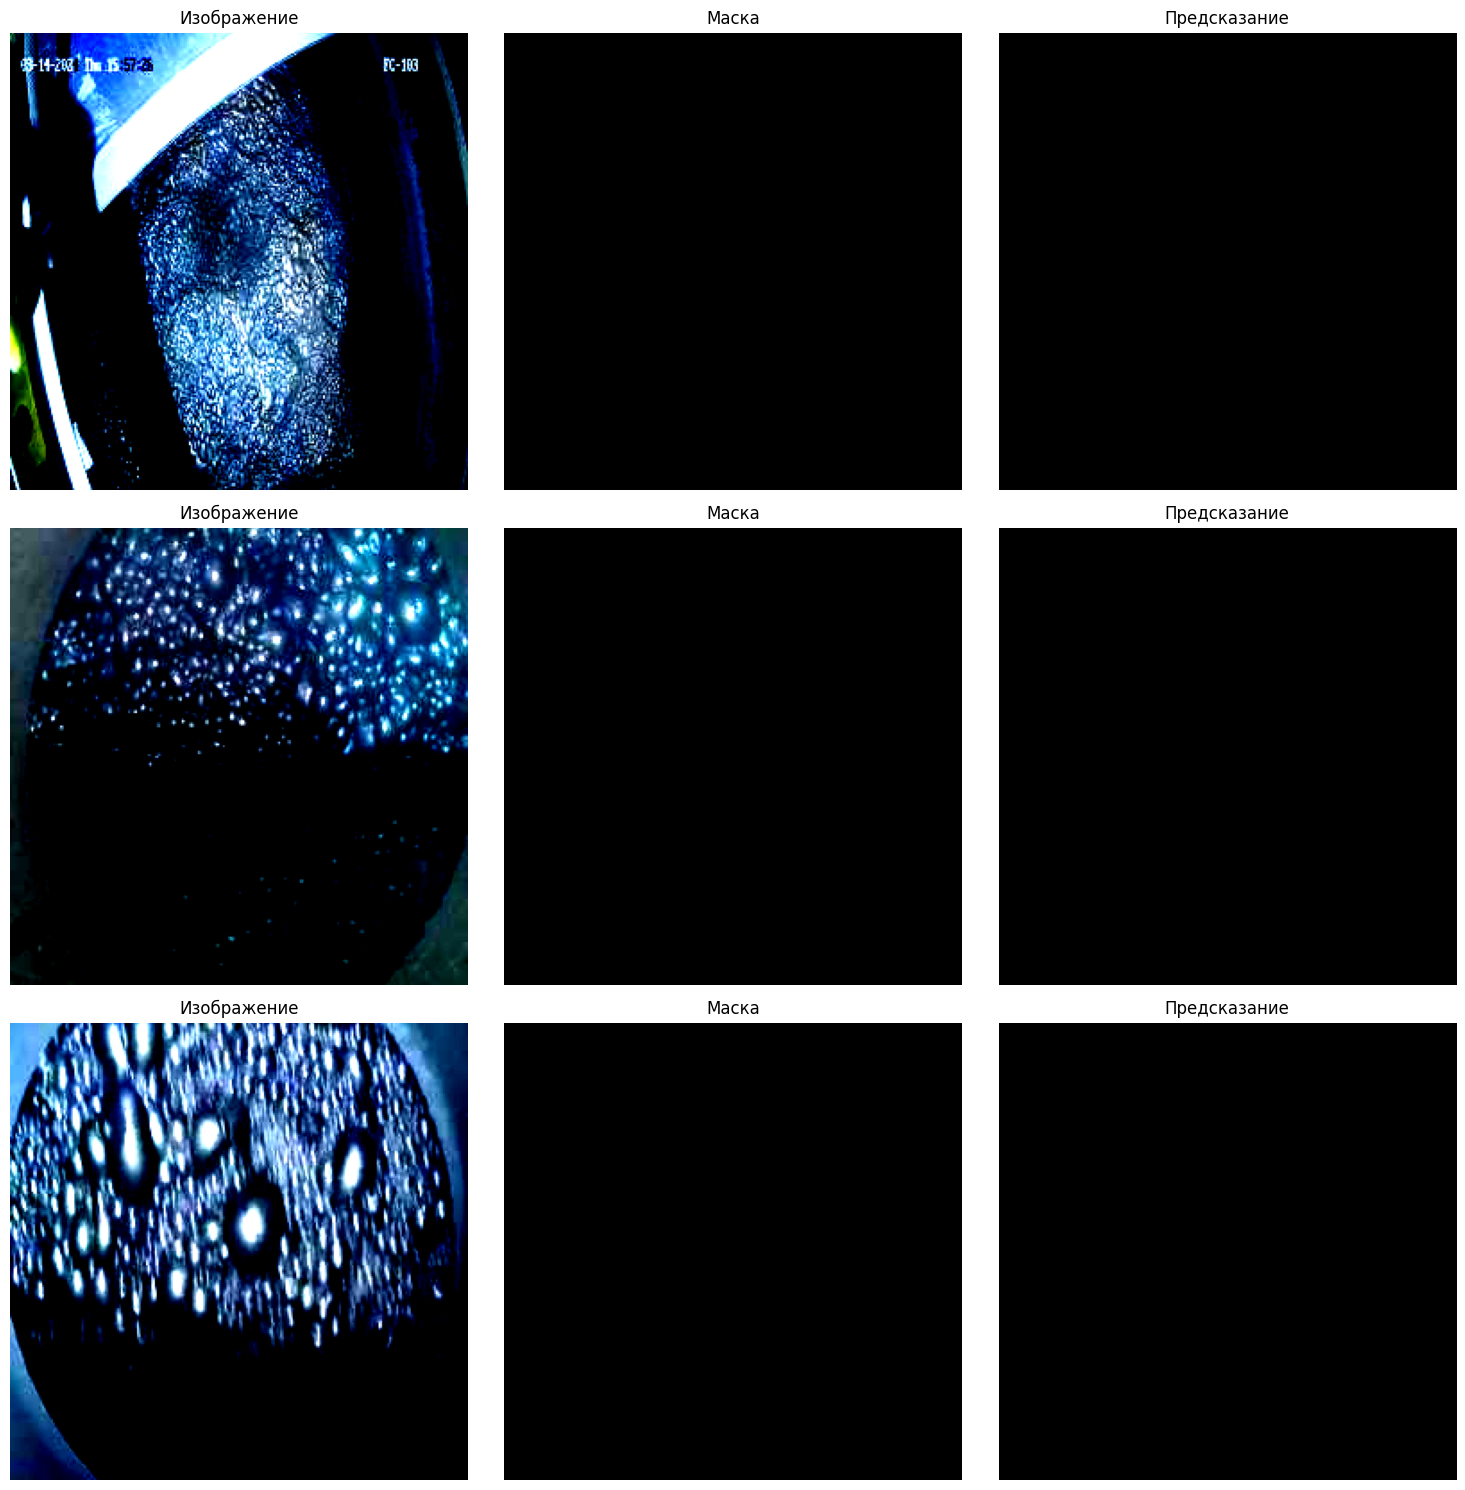

In [18]:
# Функция для вычисления метрики IoU
def calculate_iou(pred, target, num_classes=2):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()  # точка пересечения
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # точка объединения
        if union == 0:
            ious.append(float('nan'))  # Не определено
        else:
            ious.append(intersection / union)
    return ious

# Оценка модели на валидационной выборке
model.eval()
ious = []
val_loss = 0.0
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        val_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        batch_ious = calculate_iou(preds, masks, num_classes=num_classes)
        ious.extend(batch_ious)

# Среднее значение IoU, исключая NaN
ious_clean = [iou for iou in ious if not np.isnan(iou)]
mean_iou = np.mean(ious_clean)
print(f"Среднее IoU: {mean_iou:.4f}")

# Визуализация нескольких предсказаний
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]
            input_image = image.unsqueeze(0).to(device)
            output = model(input_image)['out']
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            axs[i, 0].imshow(image.permute(1, 2, 0).cpu().numpy())
            axs[i, 0].set_title("Изображение")
            axs[i, 0].axis('off')
            
            axs[i, 1].imshow(mask.cpu().numpy(), cmap='gray')
            axs[i, 1].set_title("Маска")
            axs[i, 1].axis('off')
            
            axs[i, 2].imshow(pred, cmap='gray')
            axs[i, 2].set_title("Предсказание")
            axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Визуализируем предсказания на валидационном датасете
visualize_predictions(model, val_dataset, num_samples=3)

### 6.1 Сохранение обученной модели

**Сохранение модели в двух форматах:**
1. Сохранение весов модели (`.state_dict()`):
   - Компактное хранение
   - Удобно для переноса весов
   - Путь: `datasets/best_deeplabv3_plus_model.pth`

2. Сохранение полной модели:
   - Включает архитектуру и веса
   - Путь: `/kaggle/working/full_model.pth`

> 💡 Сохранение в двух форматах обеспечивает гибкость при дальнейшем использовании модели

In [19]:
# Сохранение модели
model_save_path = os.path.join(output_dir, 'best_deeplabv3_plus_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Модель сохранена по пути: {model_save_path}")
torch.save(model, '/kaggle/working/full_model.pth')

Модель сохранена по пути: /kaggle/working/datasets/best_deeplabv3_plus_model.pth


### 6.2 Экспорт модели в формат ONNX

**Процесс конвертации:**
- Загрузка сохраненной PyTorch модели
- Обработка случая параллельной модели
- Создание тестового входного тензора
- Экспорт в формат ONNX

**Параметры экспорта:**
- Размер входного изображения: 256x256
- Версия ONNX: 11
- Оптимизация: constant folding
- Динамический батч-размер

**Конфигурация ONNX:**
- Имя входного тензора: 'input'
- Имя выходного тензора: 'output'
- Поддержка динамического размера батча

> 💡 Формат ONNX обеспечивает совместимость модели с различными фреймворками и платформами для инференса

In [20]:
def convert_model_to_onnx(model_weights_path, onnx_output_path, num_classes=2):
    """
    Конвертирует модель PyTorch в формат ONNX.
    """
    
    # Загрузка весов модели
    model = torch.load(model_weights_path, map_location='cpu')
    
    if isinstance(model, torch.nn.DataParallel):
        model = model.module
    
    # Создание фиктивного ввода
    dummy_input = torch.randn(1, 3, 256, 256)
    
    # Экспорт модели в ONNX
    torch.onnx.export(
        model,
        dummy_input,
        onnx_output_path,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    
    print(f"Модель успешно конвертирована в ONNX и сохранена по пути: {onnx_output_path}")

model_path = '/kaggle/working/full_model.pth'
output_path = '/kaggle/working/deeplabv3_plus_model.onnx'
num_classes = 2

convert_model_to_onnx(model_path, output_path, num_classes=num_classes)

/tmp/ipykernel_23/330763882.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_weights_path, map_location='cpu')


Модель успешно конвертирована в ONNX и сохранена по пути: /kaggle/working/deeplabv3_plus_model.onnx
